# California Housing Price Prediction

End-to-end regression project with preprocessing, model comparison, cross‑validation and hyperparameter tuning.


## 1. Setup

Check Python & scikit‑learn versions and import core libraries.

In [2]:
import sys
import numpy as np
import pandas as pd

assert sys.version_info >= (3, 7)

In [3]:
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import tarfile
import urllib.request

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor

## 2. Load the data

We use the **California housing** dataset from Aurélien Géron's GitHub repo and cache it locally under `datasets/housing/`.

In [5]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
        housing_tarball.extractall(path="datasets")
    csv_path = Path("datasets/housing/housing.csv")
    return pd.read_csv(csv_path)

df = load_housing_data()
df.head()

/var/folders/l4/xd8s3gr14k15hc16jj05g3gc0000gn/T/ipykernel_1492/3777560929.py:8: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path="datasets")


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## 3. Quick data inspection

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


In [8]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

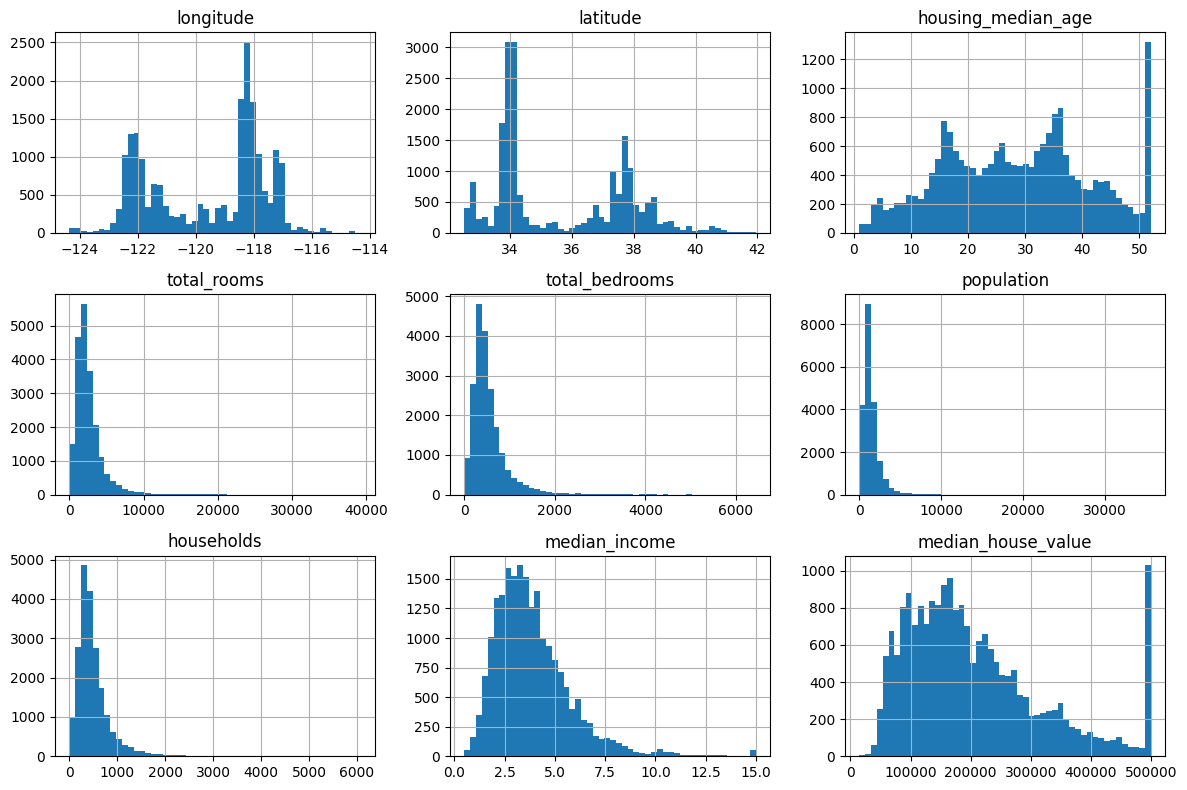

In [9]:
_ = df.hist(bins=50, figsize=(12, 8))
plt.tight_layout()
plt.show()

## 4. Train–test split

We first separate features and target, then create train/test sets. Splitting **before** any preprocessing avoids data leakage.

In [10]:
X = df.drop("median_house_value", axis=1)
y = df["median_house_value"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((16512, 9), (4128, 9))

## 5. Preprocessing pipeline

We apply different transformations to numeric and categorical columns using a `ColumnTransformer` and `Pipeline`.

- **Numeric features**: median imputation + standard scaling
- **Categorical features**: most‑frequent imputation + one‑hot encoding

In [11]:
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]

cat_attribs = ["ocean_proximity"]

In [12]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessing = ColumnTransformer(
    [
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ],
    remainder="drop",
)

In [13]:
# Sanity‑check: transformed matrices contain no NaNs
X_train_prepared = preprocessing.fit_transform(X_train)
X_test_prepared = preprocessing.transform(X_test)

print("NaNs in X_train_prepared:", np.isnan(X_train_prepared).sum())
print("NaNs in X_test_prepared:", np.isnan(X_test_prepared).sum())
print("Prepared shapes:", X_train_prepared.shape, X_test_prepared.shape)

NaNs in X_train_prepared: 0
NaNs in X_test_prepared: 0
Prepared shapes: (16512, 13) (4128, 13)


## 6. Helper functions

Convenience functions for model evaluation and comparison.

In [14]:
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

In [15]:
def cross_validate_models(models, preprocessing, X, y, cv=5):
    """Run cross‑validation for multiple models.

    Returns a DataFrame with mean CV scores.
    """
    rows = []

    for name, model in models.items():
        print(f"Running CV for: {name}")

        pipe = Pipeline([
            ("preprocessing", preprocessing),
            ("model", model),
        ])

        r2_scores = cross_val_score(
            pipe, X, y,
            cv=cv,
            scoring="r2",
            n_jobs=-1,
        )

        rmse_scores = -cross_val_score(
            pipe, X, y,
            cv=cv,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1,
        )

        mae_scores = -cross_val_score(
            pipe, X, y,
            cv=cv,
            scoring="neg_mean_absolute_error",
            n_jobs=-1,
        )

        rows.append([
            name,
            r2_scores.mean(),
            rmse_scores.mean(),
            mae_scores.mean(),
            r2_scores.mean() * 100,
        ])

    results = pd.DataFrame(
        rows,
        columns=["Model", "R2_mean", "RMSE_mean", "MAE_mean", "Performance_%"],
    )
    return results.sort_values(by="R2_mean", ascending=False).reset_index(drop=True)

In [16]:
def grid_search_all_models(models, param_grids, preprocessing, X_train, y_train, cv=3):
    """Run GridSearchCV for each model and return a summary DataFrame and dict of best estimators."""
    results = []
    best_models = {}

    for name, model in models.items():
        print(f"\nGrid search for: {name}")

        pipe = Pipeline([
            ("preprocessing", preprocessing),
            ("model", model),
        ])

        grid = GridSearchCV(
            pipe,
            param_grid=param_grids[name],
            cv=cv,
            scoring="r2",
            n_jobs=-1,
            verbose=2,
        )
        grid.fit(X_train, y_train)

        best_models[name] = grid.best_estimator_
        best_r2 = grid.best_score_
        results.append([
            name,
            best_r2,
            best_r2 * 100,
            grid.best_params_,
        ])

    summary = pd.DataFrame(
        results,
        columns=["Model", "Best_CV_R2", "Performance_%", "Best_params"],
    )
    return summary.sort_values(by="Best_CV_R2", ascending=False).reset_index(drop=True), best_models

In [17]:
def evaluate_best_models(best_models, X_test, y_test):
    rows = []
    for name, model in best_models.items():
        print(f"Evaluating on test set: {name}")
        y_pred = model.predict(X_test)
        rmse, mae, r2 = regression_metrics(y_test, y_pred)
        rows.append([name, rmse, mae, r2, r2 * 100])
    return pd.DataFrame(
        rows,
        columns=["Model", "RMSE", "MAE", "R2", "Performance_%"],
    ).sort_values(by="R2", ascending=False).reset_index(drop=True)

## 7. Model zoo

We compare a set of tree‑based and kernel models that are well‑suited for tabular regression.

In [18]:
models = {
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
    ),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Extra Trees": ExtraTreesRegressor(random_state=42, n_jobs=-1),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "SVR (RBF)": SVR(kernel="rbf"),
}

In [19]:
param_grids = {
    "Gradient Boosting": {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.1, 0.05],
        "model__max_depth": [3, 5],
        "model__subsample": [1.0, 0.8],
    },
    "XGBoost": {
        "model__n_estimators": [200, 400],
        "model__learning_rate": [0.1, 0.05],
        "model__max_depth": [4, 6],
        "model__subsample": [1.0, 0.8],
        "model__colsample_bytree": [1.0, 0.8],
    },
    "Random Forest": {
        "model__n_estimators": [200, 400],
        "model__max_depth": [None, 10, 20],
        "model__max_features": ["sqrt", "log2"],
        "model__min_samples_split": [2, 5],
        "model__min_samples_leaf": [1, 2],
    },
    "Extra Trees": {
        "model__n_estimators": [200, 400],
        "model__max_depth": [None, 10, 20],
        "model__max_features": ["sqrt", "log2"],
        "model__min_samples_split": [2, 5],
        "model__min_samples_leaf": [1, 2],
    },
    "Decision Tree": {
        "model__max_depth": [None, 5, 10, 20],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
    },
    "SVR (RBF)": {
        "model__C": [10, 100],
        "model__gamma": ["scale", 0.1],
        "model__epsilon": [0.1, 0.01],
    },
}

## 8. Baseline cross‑validation comparison

In [20]:
cv_results = cross_validate_models(models, preprocessing, X, y, cv=5)
cv_results

Running CV for: Gradient Boosting
Running CV for: XGBoost
Running CV for: Random Forest
Running CV for: Extra Trees
Running CV for: Decision Tree
Running CV for: SVR (RBF)


,Model,R2_mean,RMSE_mean,MAE_mean,Performance_%
0,XGBoost,0.827541,47907.178605,31633.228130,82.754093
1,Random Forest,0.819561,48988.594959,31818.052571,81.956132
2,Extra Trees,0.798300,51800.555078,34423.434076,79.830046
3,Gradient Boosting,0.770774,55225.971803,38425.913155,77.077384
4,Decision Tree,0.641018,68987.712065,43518.622771,64.101832
5,SVR (RBF),-0.048394,118145.169987,87992.233877,-4.839377


## 9. Hyperparameter tuning with Grid Search

In [21]:
grid_results, best_models = grid_search_all_models(
    models=models,
    param_grids=param_grids,
    preprocessing=preprocessing,
    X_train=X_train,
    y_train=y_train,
    cv=3,
)
grid_results


Grid search for: Gradient Boosting
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Grid search for: XGBoost
Fitting 3 folds for each of 32 candidates, totalling 96 fits

Grid search for: Random Forest
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Grid search for: Extra Trees
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=200, model__subsample=1.0; total time=   6.5s
[CV] END model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=1.0; total time=   5.0s
[CV] END model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=0.8; total time=   8.5s
[CV] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=200, model__subsample=0.8; total time=   5.3s
[CV] END model__learning_rate=0.05, model__max_depth=5, model__n_estimators=200, model__subsample=1.0; total time=   9.5s
[CV] END model__colsamp

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


_estimators=400; total time=  10.9s
[CV] END model__max_depth=None, model__max_features=log2, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   6.2s
[CV] END model__max_depth=None, model__max_features=log2, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=400; total time=  11.5s
[CV] END model__max_depth=None, model__max_features=log2, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=400; total time=  10.4s
[CV] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=400; total time=   7.4s
[CV] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=400; total time=   7.3s
[CV] END model__max_depth=10, model__max_features=log2, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=400; total time=   7.1s
[CV] END model__max_depth=10

,Model,Best_CV_R2,Performance_%,Best_params
0,XGBoost,0.836293,83.629317,"{'model__colsample_bytree': 0.8, 'model__learn..."
1,Gradient Boosting,0.822977,82.297708,"{'model__learning_rate': 0.1, 'model__max_dept..."
2,Random Forest,0.808041,80.804068,"{'model__max_depth': None, 'model__max_feature..."
3,Extra Trees,0.800225,80.022474,"{'model__max_depth': None, 'model__max_feature..."
4,Decision Tree,0.722335,72.233544,"{'model__max_depth': 10, 'model__min_samples_l..."
5,SVR (RBF),0.254230,25.423035,"{'model__C': 100, 'model__epsilon': 0.1, 'mode..."


[CV] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=200, model__subsample=1.0; total time=   6.5s
[CV] END model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time=   4.3s
[CV] END model__learning_rate=0.1, model__max_depth=5, model__n_estimators=200, model__subsample=0.8; total time=   8.5s
[CV] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=200, model__subsample=0.8; total time=   5.4s
[CV] END model__learning_rate=0.05, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time=   4.3s
[CV] END model__learning_rate=0.05, model__max_depth=5, model__n_estimators=200, model__subsample=0.8; total time=   7.5s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.1, model__max_depth=4, model__n_estimators=200, model__subsample=0.8; total time=   0.5s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__subsa

## 10. Final evaluation on the test set

In [22]:
test_results = evaluate_best_models(best_models, X_test, y_test)
test_results

Evaluating on test set: Gradient Boosting
Evaluating on test set: XGBoost
Evaluating on test set: Random Forest
Evaluating on test set: Extra Trees
Evaluating on test set: Decision Tree
Evaluating on test set: SVR (RBF)


,Model,RMSE,MAE,R2,Performance_%
0,XGBoost,45504.349377,29680.968385,0.850630,85.063046
1,Gradient Boosting,48391.260308,32126.407669,0.831076,83.107649
2,Random Forest,50204.527159,33569.687379,0.818180,81.817986
3,Extra Trees,51535.662861,34714.648900,0.808410,80.841039
4,Decision Tree,60547.979111,40094.013435,0.735543,73.554272
5,SVR (RBF),96743.584235,67330.438028,0.324850,32.484953


## 11. Persist the final model

In [23]:
import joblib

best_model_name = test_results.iloc[0]["Model"]
best_pipeline = best_models[best_model_name]
joblib.dump(best_pipeline, f"best_model_{best_model_name.replace(' ', '_').lower()}.joblib")

['best_model_xgboost.joblib']